In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""
import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random
from gym_pdsystem.envs.pdsystem_env import PDSystemEnv

import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct


from matplotlib import animation, rc
import matplotlib.pyplot as plt
from IPython.display import HTML


#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
episode_length = 30
seed = 42

system = PDSystemEnv()
env = gym.make("PDSystemEnv-v0")
env._max_episode_steps = episode_length

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


[42]

In [3]:
def leftmost_emptiest_tank_policy(s, system):
    min_boolean_indexes = np.isin(s, np.min(s))
    min_indexes = np.where(min_boolean_indexes)
    min_indexes = min_indexes[0]
    #n_min = len(min_indexes)

    possible_indexes = []
    
    for tank_visited in min_indexes:
        hypothetical_next_tank_state = s[tank_visited] + system.truck_max_loads
        #print(hypothetical_next_tank_state, system.tank_max_loads[tank_visited])
        if hypothetical_next_tank_state <= system.tank_max_loads[tank_visited]:
                    possible_indexes.append(tank_visited)
    
    
    if len(possible_indexes) != 0:
        tank_to_go = possible_indexes[0] # THIS IS WHAT CHANGES WITH RESPECT TO THE emptiest_tank_policy()
        return tank_to_go
    else:
        return system.n #stay in the depot

# Creating train, validation and test sets

In [4]:
################################################################################
# ENSURE THIS PARAMETER VALUES ARE SET AT THE BEGINNING OF THE pdsystem_env.py!!
################################################################################

# Example k = 1 (trucks), n = 3 (tanks)
TANK_MAX_LOADS = np.array([100., 200, 100.])
LEVEL_PERCENTAGES = np.array([ #b , c, e
                                                [0.02, 0.31, 0.9],
                                                [0.01, 0.03, 0.9],
                                                [0.05, 0.16, 0.9]
                                                   ])
TRUCK_MAX_LOADS = np.array([50.])
GRAPH_WEIGHTS = np.array([32., 159., 162., 0.])

DISCRETE = False
########################################

In [5]:
seed = 42
np.random.seed(seed)
system = PDSystemEnv()

N_TRAIN = 10**4; SEED_TRAIN = 42; train_file = 'train.txt'
N_VAL = 10**3; SEED_VAL = 50; validation_file = 'validation.txt'
N_TEST = 10**3; SEED_TEST = 58; test_file = 'test.txt'

round_decimals = 5

CREATE_DATASETS = False

def create_datasets(outputfile, n_observations, seed = None):   
    if seed != None:
        np.random.seed(seed)
        
    with open('{}'.format(outputfile),'w') as f:
        np.savetxt(f, [np.array(['tank1', 'tank2', 'tank3', 'target'])], fmt = "%s", delimiter=',')
        for i in range(n_observations):
            obs = []
            for max_load in TANK_MAX_LOADS:
                random_load = np.random.random() * max_load
                obs.append(np.round(random_load,round_decimals)  )

            obs.append(leftmost_emptiest_tank_policy(np.array(obs), system))   
            np.savetxt(f, [np.array(obs)], fmt = ('%f','%f', '%f', '%d'), delimiter=',')  #!! fmt only for n=3

if CREATE_DATASETS:          
    create_datasets(train_file, N_TRAIN, SEED_TRAIN) 
    create_datasets(validation_file, N_VAL, SEED_VAL)      
    create_datasets(test_file, N_TEST, SEED_TEST)            

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Exploring data sets

In [6]:
import pandas as pd

In [7]:
train = pd.read_table(train_file, sep = ",")
test = pd.read_table(test_file, sep = ",")
validation = pd.read_table(validation_file, sep = ",")

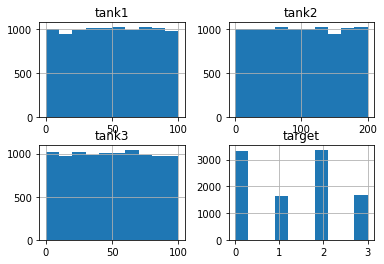

In [8]:
train.hist()
plt.show()

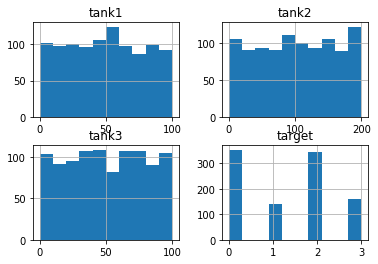

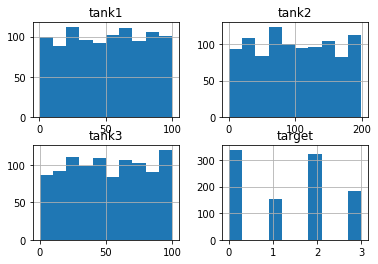

In [9]:
test.hist()
validation.hist()

plt.show()

In [10]:
y_train = train["target"].values#.reshape((N_TRAIN, ))
X_train = train[["tank1", "tank2","tank3"]].values

y_test = test["target"].values#.reshape((N_TEST, ))
X_test = test[["tank1", "tank2","tank3"]].values

y_val = validation["target"]#.reshape((N_VAL, ))
X_val = validation[["tank1", "tank2","tank3"]].values

In [11]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

# Stochastic gradient descent classifier 

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix

In [14]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train);

## Cross validation accuracy

In [15]:
CV = 10

In [16]:
cvs = cross_val_score(sgd_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.805050233881416


In [17]:
from sklearn.preprocessing import StandardScaler


In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [19]:
cvs = cross_val_score(sgd_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9026149060019663


## Error Analysis

In [20]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3218,   33,   64,    8],
       [ 112, 1420,   45,   66],
       [ 198,   89, 3027,   52],
       [ 188,   64,   55, 1361]])

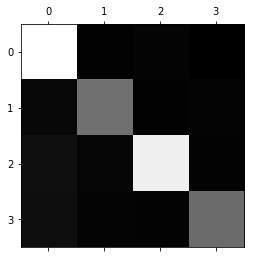

In [21]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [22]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

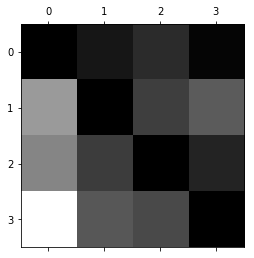

In [23]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Test prediction accuracy of the model trained on the whole train set

In [24]:
y_test_pred = sgd_clf.predict(X_test)

In [25]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[344,  10,   0,   0],
       [  9, 119,  13,   0],
       [ 30,  14, 300,   0],
       [ 73,  25,  16,  47]])

In [26]:
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.81

In [27]:
sgdscaled_clf = SGDClassifier(random_state = 42)
sgdscaled_clf.fit(X_train_scaled, y_train);

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

y_test_scaled_pred = sgdscaled_clf.predict(X_test_scaled)
conf_mx = confusion_matrix(y_test, y_test_scaled_pred)
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.928

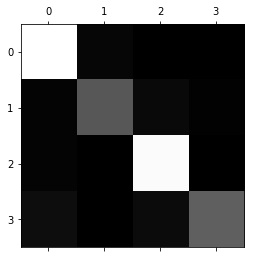

In [28]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [29]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

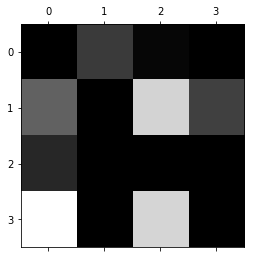

In [30]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Random forest classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train);

## Cross validation accuracy

In [32]:
CV = 10

In [33]:
cvs = cross_val_score(rf_clf, X_train, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score: ", np.mean(cvs))

Average cross validation score:  0.9851987684034821


In [34]:
from sklearn.preprocessing import StandardScaler


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [36]:
cvs = cross_val_score(rf_clf, X_train_scaled, y_train, cv = CV, scoring = "accuracy")
print("Average cross validation score for scaled train data: ", np.mean(cvs));

Average cross validation score for scaled train data:  0.9851987684034821


## Error Analysis

In [37]:
y_train_pred = cross_val_predict(rf_clf, X_train_scaled, y_train, cv = CV)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3285,   17,   20,    1],
       [  23, 1594,   13,   13],
       [  32,   19, 3315,    0],
       [   0,   10,    0, 1658]])

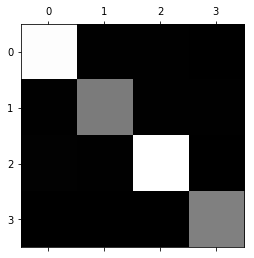

In [38]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [39]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

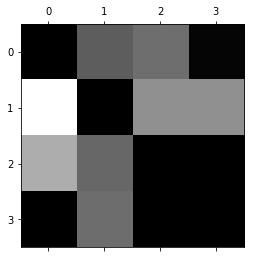

In [40]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Test prediction accuracy of the model trained on the whole train set

In [41]:
y_test_pred = rf_clf.predict(X_test)

In [42]:
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[349,   3,   2,   0],
       [  0, 140,   0,   1],
       [  2,   0, 342,   0],
       [  0,   2,   0, 159]])

In [43]:
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.99

In [44]:
rfscaled_clf = RandomForestClassifier(random_state = 42)
rfscaled_clf.fit(X_train_scaled, y_train);

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

y_test_scaled_pred = rfscaled_clf.predict(X_test_scaled)
conf_mx = confusion_matrix(y_test, y_test_scaled_pred)
test_accuracy = np.trace(np.asarray(conf_mx))/conf_mx.sum()
test_accuracy

0.977

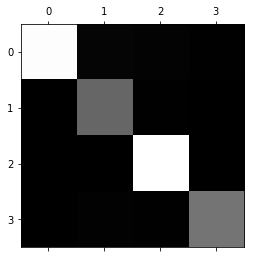

In [45]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [46]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

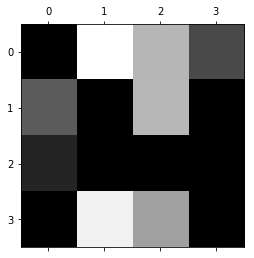

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

# Neural Network Classifier

In [ ]:
class NNClassifier(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.
    """

    def __init__(self, sess, learning_rate):
        self.sess = sess
        self.learning_rate = learning_rate

        # Network architecture
        #self.action, self.y, self.X = self.create_network()
        self.action = self.create_network()

        self.network_params = tf.trainable_variables()
        
    def create_network(self):
        with tf.name_scope("dnn"):
            #inputs = tflearn.input_data(shape=[None, self.s_dim])
            tf.set_random_seed(seed)
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = 20; activation1 = tf.nn.elu
            n_hidden2 = 6; activation2 = tf.nn.elu
            n_outputs = env.action_space.shape[1]

            self.initializer = tf.contrib.layers.variance_scaling_initializer()

            # 2. Build the Neural Network
            
            self.X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            self.y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(self.X, n_hidden1, activation = activation1,
                                     kernel_initializer = self.initializer)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = self.initializer)
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = self.initializer)
            
        with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = self.y,
                                                                      logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
        with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            self.optimize = optimizer.minimize(loss)
            
        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, self.y, 1)
            self.accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
      
        with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a random action (where to go) based on the estimated probabilities
            self.action = tf.multinomial(tf.log(outputs), num_samples = 1)

        self.init = tf.global_variables_initializer()
        
        return self.action#, y, X

    def train(self,X,y):
        self.sess.run(self.optimize, feed_dict={
            self.y: y,
            self.X: X
        })

    def predict_action(self, X, y):
        return self.sess.run(self.action, feed_dict={
            self.X: X,
            self.y: y
        })
    
    def get_accuracy(self, X, y):
        return self.sess.run(self.accuracy, feed_dict={
            self.X: X,
            self.y: y
        })

    def get_num_trainable_vars(self):
        return self.num_trainable_vars

    

In [86]:
#BOOK ML
def fetch_batch(X,y,epoch, batch_index, batch_size, data_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(data_size, size=batch_size)  # not shown
    X_batch = X[indices] # not shown
    y_batch = y[indices] # not shown
    return X_batch, y_batch

In [89]:
np.random.seed(42)

epochs = 5000
batch_size = 100
n_batches = int(np.ceil(N_TRAIN/ batch_size))

learning_rate = 0.01

X = X_train
y = y_train

m = y.shape[0]

summary_freq = np.ceil(epochs/10)

#saver = tf.train.Saver()
####
#X_train.dtype = 'float32'
#X_val.dtype = 'float32'
#X_test.dtype = 'float32'
###

with tf.Session() as sess:
    nn_clf = NNClassifier(sess, learning_rate)
    nn_clf.create_network()
    nn_clf.init.run()
    for epoch in range(epochs+1):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(X,y,epoch, batch_index, batch_size, m)
            #print("Xbatch shape",X_batch.shape, "y_batch shape", y_batch.shape)
            nn_clf.train(X_batch, y_batch)
        acc_train = nn_clf.get_accuracy(X_batch, y_batch)
        acc_val = nn_clf.get_accuracy(X_val, y_val)
        if epoch % summary_freq  == 0:
            print("Epoch: ", epoch, " Train accuracy: ", acc_train, " Validation accuracy: ", acc_val)
        #if epoch == 3000:
            #break;
            
    acc_test = nn_clf.get_accuracy(X_test, y_test)
    print("Epoch: ", epoch, " Train accuracy: ", acc_train, " Validation accuracy: ", acc_val,
         " Test accuracy: ", acc_test)
            
    #save_path = saver.save(sess, "./final_nn_classifier.ckpt")
    

Epoch:  0  Train accuracy:  0.88  Validation accuracy:  0.819
Epoch:  500  Train accuracy:  1.0  Validation accuracy:  0.993
Epoch:  1000  Train accuracy:  1.0  Validation accuracy:  0.984
Epoch:  1500  Train accuracy:  0.99  Validation accuracy:  0.993
Epoch:  2000  Train accuracy:  1.0  Validation accuracy:  0.995
Epoch:  2500  Train accuracy:  1.0  Validation accuracy:  0.989
Epoch:  3000  Train accuracy:  0.98  Validation accuracy:  0.995
Epoch:  3500  Train accuracy:  0.99  Validation accuracy:  0.991
Epoch:  4000  Train accuracy:  0.99  Validation accuracy:  0.977
Epoch:  4500  Train accuracy:  0.96  Validation accuracy:  0.978
Epoch:  5000  Train accuracy:  1.0  Validation accuracy:  0.989
Epoch:  5000  Train accuracy:  1.0  Validation accuracy:  0.989  Test accuracy:  0.996


In [73]:
y_train.shape[0]
X_train.shape

(10000, 3)

In [ ]:
X_train.dtype = 'float32'

In [ ]:
X_train.dtype

In [ ]:
X_train

In [ ]:
X_train